In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [28]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [29]:
spacy_de = spacy.load("de_core_news_sm")
spacy_en = spacy.load("en_core_web_sm")

In [30]:
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [60]:
SRC = Field(tokenize=tokenize_de, init_token='<sos>', eos_token = "<eos>", lower=True, include_lengths=True)
TRG = Field(tokenize=tokenize_en, init_token='<sos>', eos_token = "<eos>", lower=True)

In [61]:
train_data, val_data, test_data = Multi30k.splits(exts=('.de', '.en'), fields=(SRC, TRG))

In [62]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
train_iter, val_iter, test_iter = BucketIterator.splits((train_data, val_data, test_data), batch_size = 128,
                                                       sort_within_batch=True,
                                                       sort_key=lambda x :len(x.src),
                                                       device = device)

### build encoder

In [75]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)
        
        self.fc = nn.Linear(enc_hid_dim*2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        embedded = self.dropout(self.embedding(src))
        # embedded = [seq_len, batch, embed_dim]
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len) # 已经是逆序排好序的,且长度给定的
        
        packed_outputs, hidden = self.rnn(packed_embedded)
        
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        # outputs = [seq_len, batch, enc_hid_dim*2]
        
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        # hidden = [batch, dec_hid_dim]
        return outputs, hidden

In [140]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.atten = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)
    
    def forward(self, hidden, encoder_outputs, mask):
        """
        加入了mask这个常用的功能
        """
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # seq_len, batch, enc_dim*2 -> batch, seq_len, enc_dim*2
        
        energy = torch.tanh(self.atten(torch.cat((hidden, encoder_outputs), dim=2)))
        # energy = [batch, seq_len, dec_hid_dim]
        attention = self.v(energy).squeeze(2)
        # attention = [batch, seq_len, 1] - > [batch, seq_len]
        
#         print('mask shape is:',mask.shape)
#         print('attention shape is: ', attention.shape)
        attention = attention.masked_fill(mask==0, -1e10) # mask等于0的地方全部设置为value=-1e0
        
        return F.softmax(attention, dim=1)

### decode

In [141]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU(enc_hid_dim * 2 + emb_dim, dec_hid_dim)
        
        self.fc = nn.Linear(enc_hid_dim*2 + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        # encoder_outputs = [src, batch, enc_hid_dim*2]
        input = input.unsqueeze(0)
        # input = [1, batch_size]
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs, mask)
        
        a = a.unsqueeze(1)
        # a = [batch, 1, src_len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        weighted = torch.bmm(a, encoder_outputs)
        # batch, 1, enc_hid_dim*2
        
        weighted = weighted.permute(1, 0 ,2)
        
        rnn_input = torch.cat((embedded, weighted), dim=2)
        
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc(torch.cat((output, embedded, weighted), dim=1))
        return prediction, hidden.squeeze(0), a.squeeze(1)      
        
        

In [142]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
    
    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        
        batch_size = src.shape[1]
        
        trg_len = trg.shape[0]
        
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        encoder_outputs, hidden = self.encoder(src, src_len)
        
        input = trg[0,:]
        # the first input to the decoder is <sos> tokens
        
        mask = self.create_mask(src)
        # mask = [batch, src_len]
        
        for t in range(1, trg_len):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            outputs[t] = output
            
            teacher_force = random.random() < teacher_forcing_ratio
            
            top1 = output.argmax(1)
            
            input = trg[t] if teacher_force else top1
            
        return outputs
            
            
            
            
        

In [143]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

In [144]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7854, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (atten): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [145]:
optimizer = optim.Adam(model.parameters())

In [146]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [147]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [148]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output = model(src, src_len, trg, 0) #turn off teacher forcing
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [154]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iter, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_iter, criterion)
    
    end_time = time.time()
    
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

	Train Loss: 2.767 | Train PPL:  15.913
	 Val. Loss: 3.405 |  Val. PPL:  30.125
	Train Loss: 2.420 | Train PPL:  11.244
	 Val. Loss: 3.218 |  Val. PPL:  24.977
	Train Loss: 2.129 | Train PPL:   8.410
	 Val. Loss: 3.225 |  Val. PPL:  25.145
	Train Loss: 1.904 | Train PPL:   6.712
	 Val. Loss: 3.250 |  Val. PPL:  25.786


In [153]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss = evaluate(model, test_iter, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.568 | Test PPL:  35.444 |


### inference

In [160]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 80):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [161]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

### translation the train_data

In [162]:
example_idx = 12

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'schwarzer', 'hund', 'und', 'ein', 'gefleckter', 'hund', 'kämpfen', '.']
trg = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting']


In [163]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', '.', '<eos>']


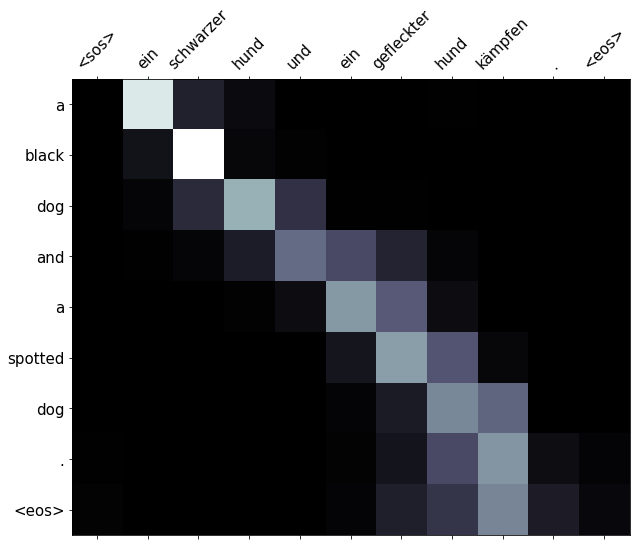

In [164]:
display_attention(src, translation, attention)

### translation the val_data

In [167]:
example_idx = 14

src = vars(val_data.examples[example_idx])['src']
trg = vars(val_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'spielt', 'ein', 'lied', 'auf', 'ihrer', 'geige', '.']
trg = ['a', 'female', 'playing', 'a', 'song', 'on', 'her', 'violin', '.']


predicted trg = ['a', 'woman', 'is', 'playing', 'song', 'on', 'a', 'violin', '.', '<eos>']


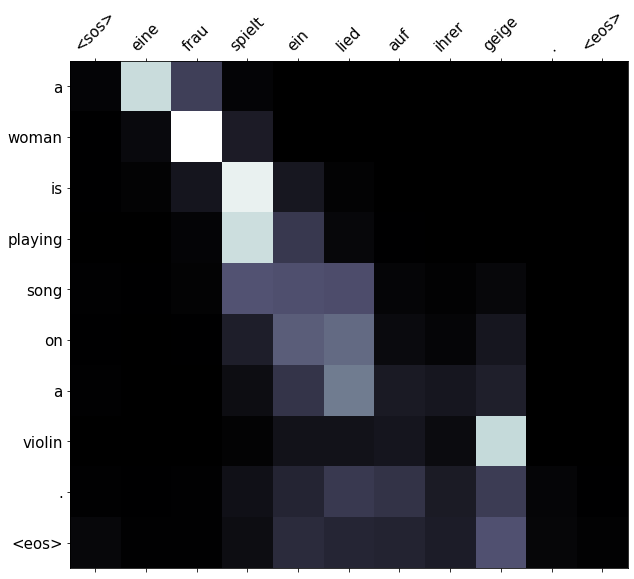

In [168]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

### translation the test data

In [169]:
example_idx = 18

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['die', 'person', 'im', 'gestreiften', 'shirt', 'klettert', 'auf', 'einen', 'berg', '.']
trg = ['the', 'person', 'in', 'the', 'striped', 'shirt', 'is', 'mountain', 'climbing', '.']


predicted trg = ['the', 'person', 'in', 'the', 'striped', 'shirt', 'is', 'climbing', 'a', 'mountain', '.', '<eos>']


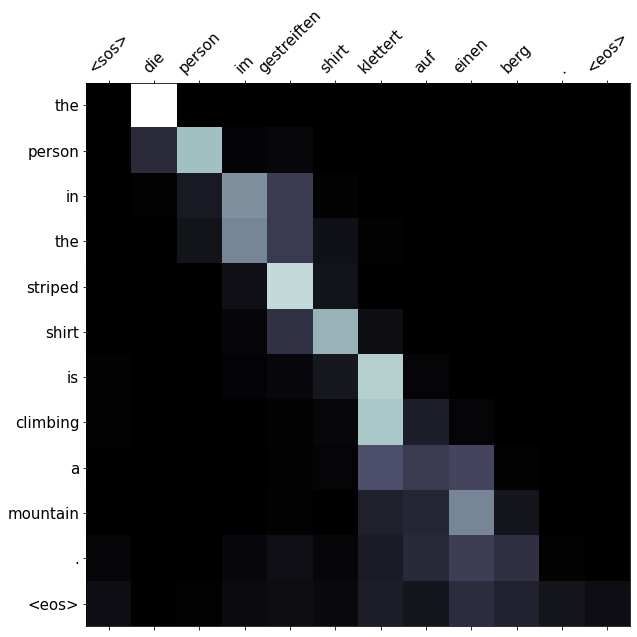

In [170]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

### BLEU

In [181]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len=100):
    trgs = []
    pred_trgs = []
    for datum in data:
        src = vars(datum)['src']
        trg = vars(datum)['trg']
#         print('datum', vars(datum))
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)
        

In [182]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 30.08
